# Feature comparison and vectorization between images

## Step 1 - Importing Necessary Libraries

In [ ]:
%%capture
!pip install scikit-image
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

## Step 2 - Load and Display the Images

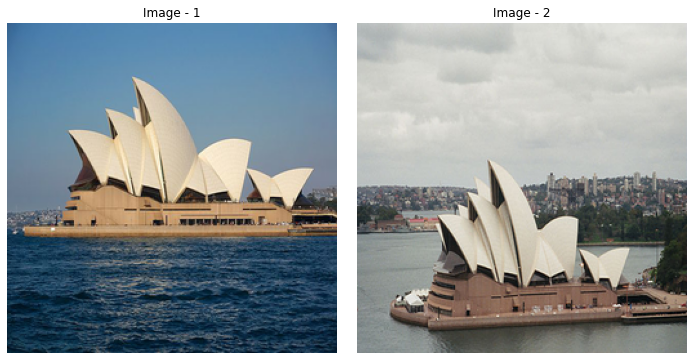

In [ ]:
image1 = Image.open('/content/opera_house_1.jpeg')
image2 = Image.open('/content/opera_house_3.jpeg')
image1 = image1.resize((256, 256), Image.ANTIALIAS)
image2 = image2.resize((256, 256), Image.ANTIALIAS)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image1)
plt.title("Image - 1")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image2)
plt.title("Image - 2")
plt.axis("off")

plt.tight_layout(pad=2)
plt.show()

## Step 3 - Apply the DELF module to the data

In [ ]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

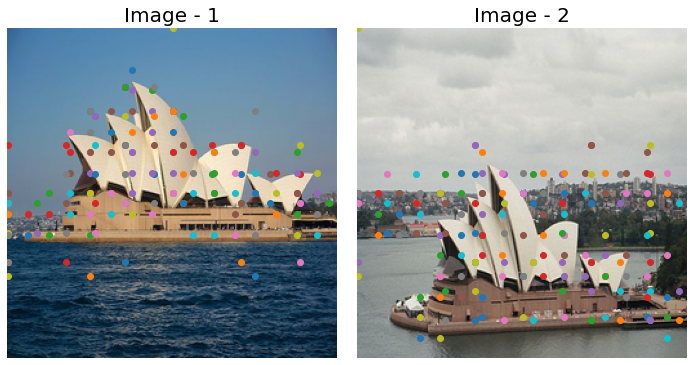

In [ ]:
def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

result1 = run_delf(image1)
result2 = run_delf(image2)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image1)
for i in result1['locations']:
  plt.scatter(i[1],i[0])
plt.title("Image - 1",fontsize=20)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image2)
plt.title("Image - 2",fontsize=20)
for i in result2['locations']:
  plt.scatter(i[1],i[0])
plt.axis("off")

plt.tight_layout(pad=2)

plt.show()

## Step 4 - Use the locations and description vectors to match the images

In [ ]:
def match_images(image1, image2, result1, result2):
  
  distance_threshold = 0.8
  num_features_1 = result1['locations'].shape[0]
  print("Loaded image 1's %d features" % num_features_1)

  num_features_2 = result2['locations'].shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  d1_tree = cKDTree(result1['descriptors'])

  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=2000)
  print('Found %d inliers' % sum(inliers))

  _, ax = plt.subplots(figsize=(20,20))
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='r')
  ax.axis('off')
  ax.set_title('DELF Similarity Results',fontsize=20)

## Step 5 - Final Result Visualize

Loaded image 1's 158 features
Loaded image 2's 181 features
Found 55 inliers


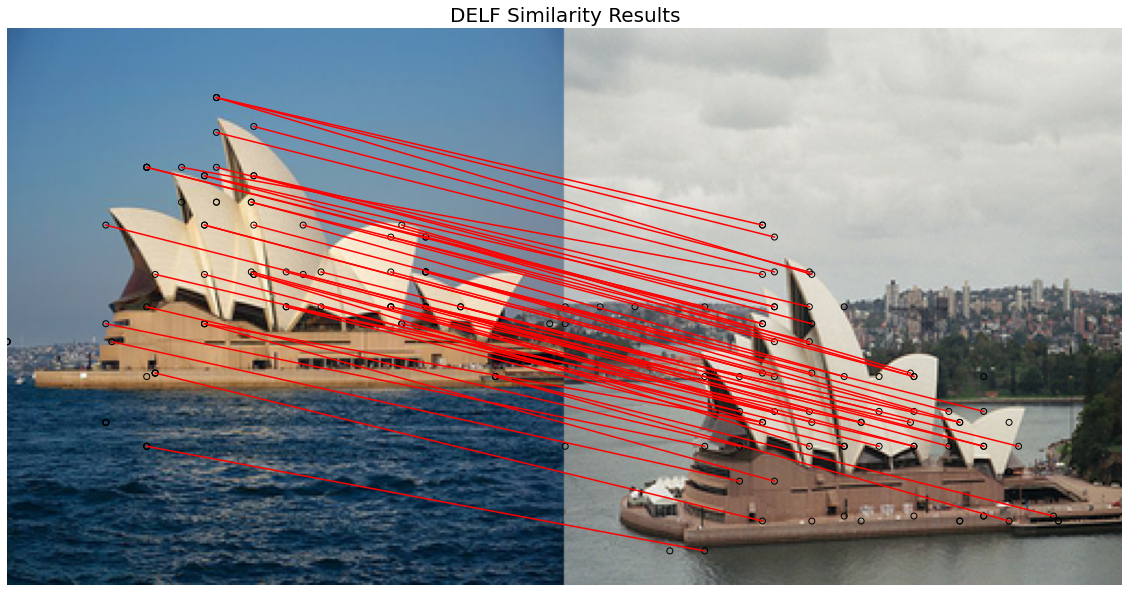

In [ ]:
match_images(image1, image2, result1, result2)

In [ ]:
def find_inliers(image1, image2, result1, result2):
  distance_threshold = 0.8
  
  num_features_1 = result1['locations'].shape[0]
  num_features_2 = result2['locations'].shape[0]

  d1_tree = cKDTree(result1['descriptors'])

  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)
  return(sum(inliers))


In [ ]:
x = "/content/opera_house_"
mat = np.zeros((5,5),dtype="int")

for i in range(1,6):
  img1_url = x+str(i)+".jpeg"
  img1 = Image.open(img1_url)
  img1 = img1.resize((256, 256), Image.ANTIALIAS)
  for j in range(1,6):
    img2_url = x+str(j)+".jpeg"
    img2 = Image.open(img2_url)
    img2 = img2.resize((256, 256), Image.ANTIALIAS)
    result1 = run_delf(img1)
    result2 = run_delf(img2)
    inliers = find_inliers(img1, img2, result1, result2)
    mat[i-1][j-1] = inliers

In [ ]:
print(mat)

[[158  27  54  28  24]
 [ 41 180  22  49  13]
 [ 59  22 181  68  41]
 [ 33  60  48 220  46]
 [ 22  17  45  50 158]]
